# Tutorial 4: 2D Poisson example using Vale

In this tutorial, we explain how to use both **GLT** and **Vale**.

Let's start with some imports

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

from vale import construct_model
import numpy as np
import os
import clapp.common.utils      as clapp_utils

# ... initializing Clapp
clapp_utils.initialize()
# ...

Don't forget to *initialize* clapp (we will be using **LUA** as a backend to run our weak formulation kernels).

To make the code easier to use, we need to define the following function, that creates and assembles the linear system given a **Vale** file.

In [14]:
# ...
def construct_form(filename, mapping, discretization):
    # ... clean input directory. needed for Fortran
    cmd = "rm -rf input"
    os.system(cmd)
    # ...

    # ... creates discretization parameters
    from clapp.disco.parameters.bspline import BSpline

    bspline_params = BSpline(discretization["n_elements"], \
                             discretization["degrees"], \
                             bc_min=[0,0], \
                             bc_max=[0,0])
    # ...

    # ... create a context from discretization
    from clapp.fema.context        import Context

    context = Context(dirname="input", \
                      discretization_params=bspline_params)
    # ...

    # ...
    pde = construct_model(filename, backend="clapp", \
                          context=context, mapping=mapping)
    # ...

    # ... accessing the pde declarations
    V           = pde["V"]
    form_a      = pde["a"]
    # ...

    # ... gets the assembler and matrix associated to the weak formulation.
    assembler_a = form_a.assembler
    matrix      = form_a.matrix
    # ...

    # ... assembling the linear system
    assembler_a.assemble()
    # ...
    
    # ... clean input directory
    cmd = "rm -rf input"
    os.system(cmd)
    # ...
    
    return form_a
# ...

We use **CAID** to create the geometry, then convert it to the *mapping* object from *CLAPP*

In [15]:
# ... creates a unit square geometry using CAID
from caid.cad_geometry import square
geometry = square()
# ...
    
# ...
from clapp.spl.mapping import Mapping
mapping = Mapping(geometry=geometry)
# ...

We specify the discretization, by giving the number of elements and spline degrees in every direction

In [16]:
# ... define a discretization
discretization = {"n_elements": [32,32], \
                  "degrees": [2,2]}
# ...

We use our user-friendly **construct_form** function to create and assemble the linear system

In [17]:
# ... discretize the bilinear form
form = construct_form(filename="../../gelato/tests/2d/inputs/poisson.vl", \
                      mapping=mapping, \
                      discretization=discretization)
# ...

Rather than calling the **glt_symbol** function we now use the function **glt_symbol_from_weak_formulation** (first without evaluation)

In [19]:
# ... compute the glt symbol without evaluation
from gelato.expression import glt_symbol_from_weak_formulation

expr = glt_symbol_from_weak_formulation(form, \
                       verbose=False, evaluate=False, \
                       discretization=discretization)
# ...

Let's print the *Latex* formula of our symbol

In [20]:
from IPython.display import Math;
from gelato.printing.latex import glt_latex;

Math(glt_latex(expr))

<IPython.core.display.Math object>

Let's now **evaluate** our symbol (in the symbolic sens) in order to do some diagnostics

In [21]:
# ... compute the glt symbol and evaluate it
expr = glt_symbol_from_weak_formulation(form, \
                                        verbose=False, evaluate=True, \
                                        discretization=discretization)
# ...

In [22]:
from sympy import latex
from gelato.printing.latex import glt_latex_names

Math(latex(expr, symbol_names=glt_latex_names()))

<IPython.core.display.Math object>

Finally, we can plot the eigenvalues of the linear system together with their approximation, using a uniform sampling of the symbol

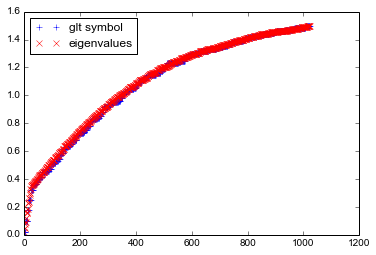

In [11]:
# ...
from gelato.expression import glt_plot_eigenvalues

glt_plot_eigenvalues(expr, discretization, \
                     mapping=mapping, \
                     matrix=form.matrix)

plt.legend(loc=2);
# ...

Always remember to clean your session by calling the finalize function from *CLAPP*

In [23]:
# ... Finalizing Clapp
clapp_utils.finalize()
# ...